# Aggregating Preferences

- Date generated: 2end Feb - 2024
- Author: Saba Esnaashari - John Francis
- Purpose: Functions and codes for theme extraction from GMC data

#### Aggregating Preferences Pipeline
1. Identify a question to analyze
2. Split the free text question by optimistic/pessimistic
3. For each of the multiple choice answers, run a cluster analysis to aggregate Rs into groups with similar arguments; identifying central Rs for direct quotes
4. For each of the multiple choice answers, extract the main reasons Rs have for holding that position 
5. For each of the multiple choice answers, quantify the support for each argument
6. For each of the multiple choice answers, pull out outliers to investigate for unique arguments

### Load In packages

In [1]:
# Quantized LLama
from ctransformers import AutoModelForCausalLM,AutoTokenizer

# Embedding Model
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.util import cos_sim

# Kmeans and PCA 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Plotting
import matplotlib.pyplot as plt

# NLP utilities
import re
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams 
import string

# Python dataframes and arrays
import pandas as pd
import numpy as np

# Misc
from collections import Counter

### Load in Data 
#### Remove NaNs from Scenario-one

In [5]:
#GMC data
questions = pd.read_csv("../Data/cleaned_analytic_file_for_viz_090224.csv")
questions.head()

#Remove NaNs. 
mask = questions.scenario_one.isnull()
print("number of NaNs in scenario one:",questions.scenario_one.isnull().sum())
questions = questions.dropna(subset=['scenario_one'])
print("Number of entries after NaNs removal", len(questions))

#Read Data
aiuse_optimism = questions["aiuse_optimism_aggregated"].tolist() # multiple choice q
scenario_one = questions["scenario_one"].tolist() # free text q


number of NaNs in scenario one: 4
Number of entries after NaNs removal 925


In [4]:
questions.tail()

,gender,pmq_aggregated,reg_status_aggregated,country_of_practice,medical_area_aggregated,inside_uk_years,inside_uk_years_aggregated,patient_facing_role,age,age_aggregated,aiuse_optimism_aggregated,used_gen_ai,used_ddss_ai,used_any_ai,scenario_one,further_info,details_ai_system
924,Woman,non-UK,Trainee,England,Psychiatry,Less than 5 years,Less than 5 years (agg),Patient facing,Under 30,Under 40,Neutral,0,0,0,"For a clinical condition, i will refer to the ...",No,NaN
925,Woman,UK,GP,England,General Practice,15-24 years,5-24 years,Patient facing,40-49,40-49 (agg),NaN,0,0,0,"I would discuss this with a colleague or boss,...",no,NaN
926,NaN,non-UK,Specialist,England,NaN,25-34 years,25+ years,Patient facing,Prefer not to say,NaN,Optimistic,0,0,0,Document the disparity. Seek consensus from a ...,Some colleagues use the auto dictate function ...,NaN
927,Man,UK,Specialist,England,Radiology,15-24 years,5-24 years,Patient facing,40-49,40-49 (agg),Pessimistic,0,0,0,i would ignore the system and report the diffe...,no,NaN
928,Man,non-UK,Locally employed doctor (LED),England,Surgery,Less than 5 years,Less than 5 years (agg),Patient facing,Under 30,Under 40,Optimistic,0,1,1,I would double-check my diagnosis/recommendati...,NaN,NELA calculations


### Split the free text question by multiple choice categories

Number of people who didn't know: 104
Percent of people who don't know: 11.24 %


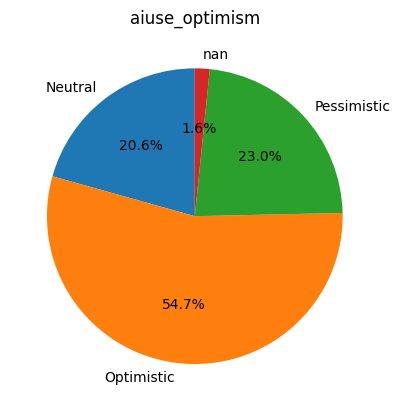

In [195]:
not_know_lists = ["I dont know","I don't know", "not know", "not sure"]
questions['not_know'] = questions['scenario_one'].apply(lambda x: 1 if any(ss in x for ss in not_know_lists) else 0)
print("Number of people who didn't know:", sum(questions['not_know']))
print("Percent of people who don't know:",round(sum(questions['not_know'])/len(questions)*100,2),"%")

categories, counts = np.unique(aiuse_optimism, return_counts=True)
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90)
plt.title('aiuse_optimism')
plt.show()

In [196]:
## Optimism by gender
print("Optimism grouped by gender:")
print(questions.groupby('gender')['aiuse_optimism_aggregated'].value_counts(normalize=True).unstack()*100)
print("\nNot know responses grouped by gender:")
print(questions.groupby('gender')['not_know'].value_counts(normalize=True).unstack()*100)

Optimism grouped by gender:
aiuse_optimism_aggregated    Neutral  Optimistic  Pessimistic
gender                                                       
Man                        17.122040   62.112933    20.765027
Woman                      26.934097   45.845272    27.220630

Not know responses grouped by gender:
not_know          0          1
gender                        
Man       90.794224   9.205776
Woman     85.515320  14.484680


In [197]:
print("Not know percentage in each of the optimism category")
questions.groupby('aiuse_optimism_aggregated')['not_know'].value_counts(normalize=True).unstack()*100

Not know percentage in each of the optimism category


not_know,0,1
aiuse_optimism_aggregated,,
Neutral,77.486911,22.513089
Optimistic,93.478261,6.521739
Pessimistic,87.793427,12.206573


## Sentiment Analysis for Scenario One

Neutral          434
Positive view    274
Negative view    217
Name: count, dtype: int64


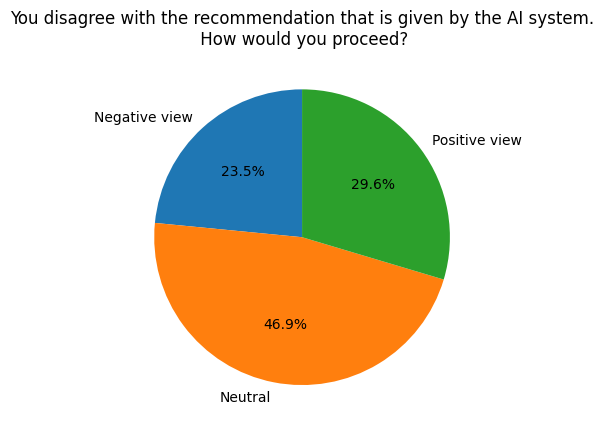

In [198]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon (if not already downloaded)


# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Categorize sentences
counter = 0
scenario_one_categories = pd.Series("" * len(scenario_one))
for sentence in scenario_one:
    sentiment_scores = sia.polarity_scores(sentence)
    
    # Classify as positive, negative, or neutral based on compound score
    if sentiment_scores['compound'] >= 0.05:
        sentiment = 'Positive view'
    elif sentiment_scores['compound'] <= -0.05:
        sentiment = 'Negative view'
    else:
        sentiment = 'Neutral'
    scenario_one_categories[counter] = sentiment
    counter+=1
questions['scenario_one_sentiment'] = scenario_one_categories
print(scenario_one_categories.value_counts())
categories, counts = np.unique(scenario_one_categories, return_counts=True)
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90)
plt.title('You disagree with the recommendation that is given by the AI system.\n How would you proceed?')
plt.show()

In [199]:
questions.to_csv("sentiment_analysis.csv")

In [200]:
#Correlation between Scenario_one optimism and AI_Use optimism. 
questions.loc[questions['scenario_one_sentiment'] == 'Positive view','scenario_one_sentiment'] = 1 
questions.loc[questions['scenario_one_sentiment'] == 'Negative view','scenario_one_sentiment'] = -1
questions.loc[questions['scenario_one_sentiment'] == 'Neutral','scenario_one_sentiment'] = 0
#print(questions['scenario_one_sentiment'].value_counts())

questions.loc[questions['aiuse_optimism_aggregated'] == 'Optimistic','aiuse_optimism_aggregated'] = 1 
questions.loc[questions['aiuse_optimism_aggregated'] == 'Pessimistic','aiuse_optimism_aggregated'] = -1
questions.loc[questions['aiuse_optimism_aggregated'] == 'Neutral','aiuse_optimism_aggregated'] = 0
#print(questions['aiuse_optimism_aggregated'].value_counts())
print(round(questions.scenario_one_sentiment.corr(questions['aiuse_optimism_aggregated'])*100,2),"% correlation")
questions.groupby('aiuse_optimism_aggregated')['scenario_one_sentiment'].value_counts(normalize=True).unstack()*100

1.52 % correlation


scenario_one_sentiment,-1,0,1
aiuse_optimism_aggregated,,,
-1,25.471698,42.45283,32.075472
0,24.083770,50.26178,25.654450
1,22.420635,47.02381,30.555556


In [201]:
# correlation between scenarity and view towards 
questions.groupby('inside_uk_years')['scenario_one_sentiment'].value_counts(normalize=True).unstack()*100

scenario_one_sentiment,-1,0,1
inside_uk_years,,,
15-24 years,21.134021,50.000000,28.865979
25-34 years,28.571429,43.506494,27.922078
35 years or more,24.210526,48.421053,27.368421
5-14 years,24.255319,46.808511,28.936170
Less than 5 years,21.363636,45.454545,33.181818
Prefer not to say,21.739130,47.826087,30.434783


In [202]:
# Using any AI seems to have a correlation with less Neutral view
questions.groupby('used_any_ai')['scenario_one_sentiment'].value_counts(normalize=True).unstack()*100

scenario_one_sentiment,-1,0,1
used_any_ai,,,
0,23.312883,48.159509,28.527607
1,24.163569,43.494424,32.342007


In [203]:
from scipy.stats import pointbiserialr
print(round(questions.scenario_one_sentiment.corr(questions['used_any_ai'])*100,2),"% correlation")

1.85 % correlation


In [205]:
correlation_coefficient, p_value = pointbiserialr(questions.loc[0:924,'used_any_ai'], questions.loc[0:924,'scenario_one_sentiment'])


In [208]:
# I think I should check if Nans are removed corrrectly otherwise rows might be changed ana analysis not reliable. 
# Change years into sceniority level. 
questions.inside_uk_years_aggregated.value_counts()
questions['inside_uk_years_aggregated'].value_counts()

inside_uk_years_aggregated
5-24 years                 431
25+ years                  250
Less than 5 years (agg)    221
Name: count, dtype: int64

### Correlation between Sceniority and Scenario One optimism

In [222]:
# Change number of working years into sceniority
questions['sceniority'] = 0
questions.loc[questions.inside_uk_years_aggregated=='5-24 years', 'sceniority'] = 1
questions.loc[questions.inside_uk_years_aggregated=='25+ years', 'sceniority'] = 2

## A slight correlation between these sceniority and scenario one sentiment. Also interesting to know if p-values is significant and also include other covariates. 
print(round(questions.scenario_one_sentiment.corr(questions['sceniority'])*100,2),"% correlation")
questions.groupby('sceniority')['scenario_one_sentiment'].value_counts(normalize=True).unstack()*100

-5.39 % correlation


scenario_one_sentiment,-1,0,1
sceniority,,,
0,21.399177,45.679012,32.921811
1,22.843823,48.251748,28.904429
2,26.907631,45.381526,27.710843


NameError: name 'texts' is not defined